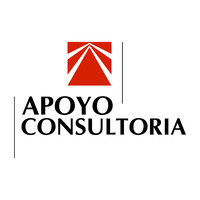

# Proyeccion

Esta libreria construye la proyeccion de nowcast usando la metodologia especificada en el punto XX.XX del informe. Se busca obtener proyecciones trimestrales usando informacion mensual y que se pueda manejar el problema de informacion faltante sin tener que realizar proyecciones de las variables faltantes.

Esta libreria realiza la proyeccion.


In [3]:
import pykalman as kalman
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os

from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos
from ipynb.fs.defs.nowcast_kalman import kalman_fed_nyc

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import pickle
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
rutaOrigen = 'inputs/'
rutaDestino = 'resultados/'
rutaModelos = 'model_nowcast/'


# Construccion de Base de datos

In [5]:
bd_mensual_t,bd_trimestral_t,bd_anual_t,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Importando resultados de la estimacion

In [6]:
with open(rutaModelos + 'nowcast_model.pkl', 'rb') as file:
    kalman = pickle.load(file)

In [7]:
X,y,n_factors,params,initial_state_mean,initial_state_covariance, _, _ = kalman

# Realizando proyecciones mensual

In [8]:
_, _, bd_S, bd_F, bd_P, bd, bd_data = kalman_fed_nyc(bd_all,X,y,n_factors,params,
                                             initial_state_mean,initial_state_covariance,0)

C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


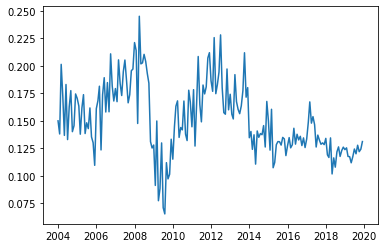

In [9]:
plt.plot(bd_P[X])

In [10]:
bd_P

,imae_Mensual_VariacionAnual,imae_com_car_Mensual_VariacionAnual
per,,
2004-01-01,0.061897,0.150044
2004-02-01,0.049983,0.138131
2004-03-01,0.113209,0.201356
2004-04-01,0.083952,0.172099
2004-05-01,0.048694,0.136841
...,...,...
2019-08-01,0.031975,0.120123
2019-09-01,0.039755,0.127902
2019-10-01,0.033907,0.122054


In [12]:
with pd.ExcelWriter(rutaDestino + 'baseNowcasting.xlsx') as writer:
    bd_P.to_excel(writer, sheet_name='Nowcast_Mensual')

### Segunda etapa

In [136]:
with open(rutaModelos + 'nowcast_2stage.pkl', 'rb') as file:
    Z, Linear_ = pickle.load(file)

In [143]:
bd_2etapa = bd_S[bd_S.columns[0]].groupby(pd.Grouper(freq = 'Q')).aggregate([lambda y: y[0], lambda y: y[1], lambda y: y[2]]).rename(columns = lambda y: y[8])
X_ = bd_2etapa.columns

bd_proyeccion = pd.DataFrame(Linear_.predict(bd_2etapa), index =  bd_2etapa.index, columns = ['Proyeccion'])
bd_proyeccion = bd_proyeccion.join(bd_all[Z].groupby(pd.Grouper(freq='Q')).sum())

In [148]:
 with pd.ExcelWriter(rutaDestino + 'baseNowcasting.xlsx', engine="openpyxl", mode="a") as writer:
        bd_proyeccion.to_excel(writer, sheet_name = 'Trimestral')

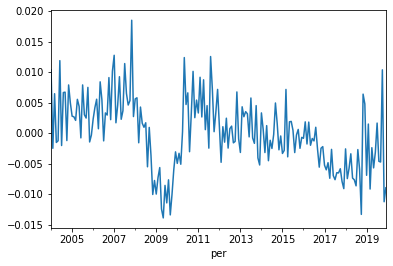

In [152]:
bd_S[bd_S.columns[0]].plot()